In [1]:
from wrangle import get_311_data, clean_311, split_separate_scale
from explore import get_chi_square, get_first_anova_test, make_dbad_relplot, get_second_anova_test, make_isLate, eval_by_dist, make_avg_days_by_dept
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
df_1= get_311_data()
df = clean_311(df_1)

In [3]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, train_scaled, validate_scaled, test_scaled = split_separate_scale(df, stratify_by= None)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428870 entries, 2497 to 495432
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   case_id                   428870 non-null  int64         
 1   open_date                 428870 non-null  datetime64[ns]
 2   due_date                  428870 non-null  datetime64[ns]
 3   closed_date               428870 non-null  datetime64[ns]
 4   is_late                   428870 non-null  object        
 5   dept                      428870 non-null  object        
 6   call_reason               428870 non-null  object        
 7   case_type                 428870 non-null  object        
 8   case_status               428870 non-null  object        
 9   source_id                 428870 non-null  object        
 10  address                   428870 non-null  object        
 11  council_district          428870 non-null  int64         
 12 

In [5]:
df.council_district.isna().sum()

0

In [6]:
train.head()

,case_id,open_date,due_date,closed_date,is_late,dept,call_reason,case_type,case_status,source_id,address,council_district,longitude,latitude,days_open,resolution_days_due,days_before_or_after_due,level_of_delay,district_0,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,district_10,zipcode
413287,1016756563,2021-03-22,2021-03-25,2021-03-25,YES,Solid Waste Management,waste,No Pickup,Closed,Web Portal,"2430 LAKE LOUISE, SAN ANTONIO, 78228",7,2098452.0,13715006.0,3.0,3,0.0,On Time Response,0,0,0,0,0,0,0,1,0,0,0,78228
454053,1016816279,2021-04-19,2021-04-21,2021-04-19,NO,Trans & Cap Improvements,streets,Pavement Repair (Pothole),Closed,Web Portal,FAITH DR and LURA LN,7,2100261.0,13718518.0,0.0,2,2.0,Early Response,0,0,0,0,0,0,0,1,0,0,0,NaN
412793,1016755838,2021-03-22,2021-03-29,2021-03-31,YES,Solid Waste Management,waste,Carts(Removed from Service),Closed,Web Portal,"734 DONALDSON AVE, SAN ANTONIO, 78201",7,2115439.0,13716364.0,9.0,7,-2.0,On Time Response,0,0,0,0,0,0,0,1,0,0,0,78201
51664,1016211764,2020-05-26,2020-05-27,2020-05-26,NO,Unknown,traffic,Traffic Signals (Maintenance_Emergency),Closed,Web Portal,PEREIDA ST and S ST MARYS ST,1,2131315.0,13698007.0,0.0,1,1.0,Early Response,0,1,0,0,0,0,0,0,0,0,0,NaN
383234,1016708721,2021-02-26,2021-03-05,2021-03-01,NO,Solid Waste Management,waste,Carts(Damaged Cart),Closed,Web Portal,"6707 HARMONY FARM, SAN ANTONIO, 78249",8,2089165.0,13750628.0,3.0,7,4.0,Early Response,0,0,0,0,0,0,0,0,1,0,0,78249


## 5. Does category/department affect response time?

<Figure size 1440x720 with 0 Axes>

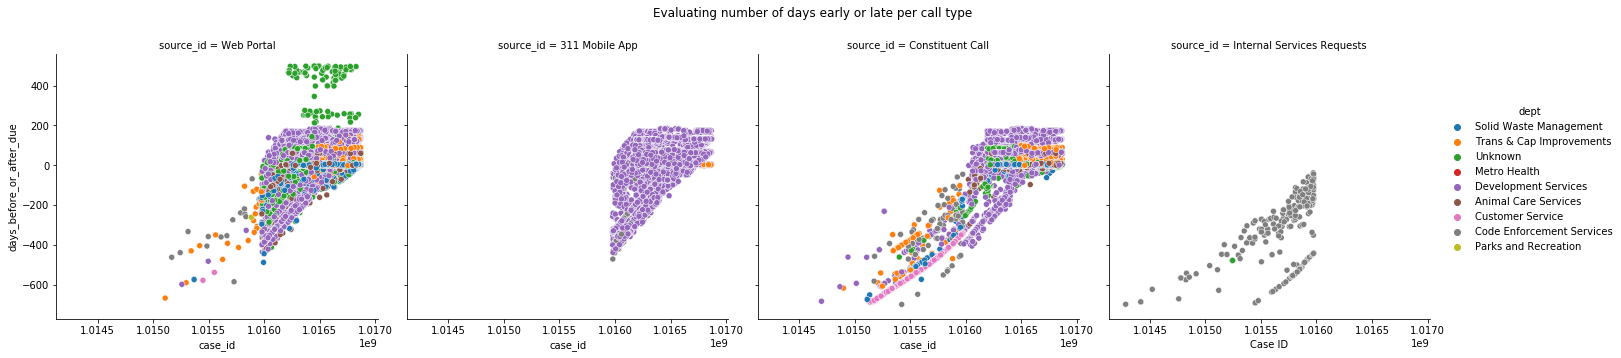

In [7]:
make_dbad_relplot(train)

#### Hypothesis Testing #1 (ANOVA)

$H_0$: There is no difference in mean days open between the departments.

$H_a$: There is a significant difference in days open in animal care services.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [8]:
get_first_anova_test(train)

We reject the null hypothesis that there is no difference in mean days open between the departments.


#### Is animal care services slower than the rest of the departments? If not, what is the slowest department?

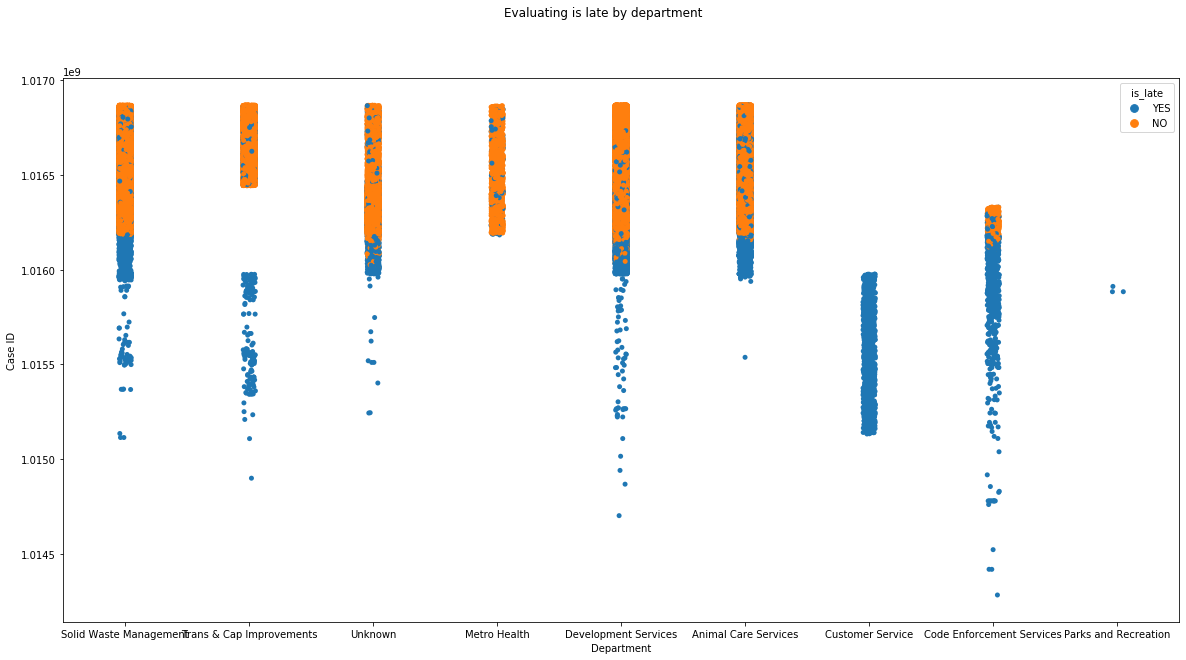

In [9]:
make_isLate(train)

<Figure size 1440x720 with 0 Axes>

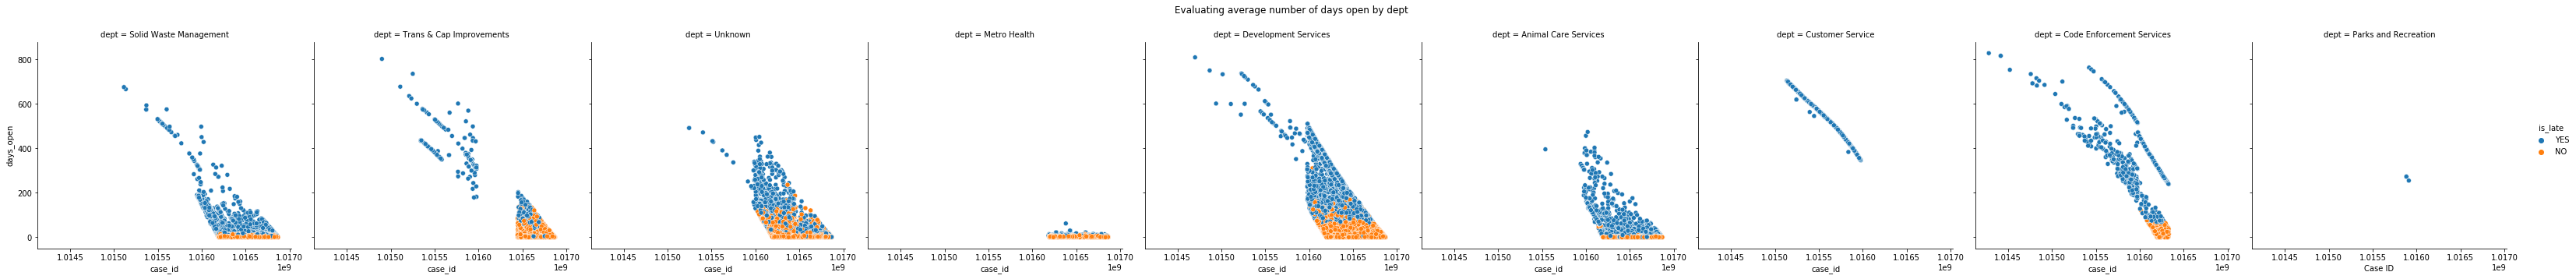

In [10]:
make_avg_days_by_dept(train)

## 6. Is response time for issue X different between geographical location Y when compared to the average response time? (or other geographical location?)

In [ ]:
    train['council_district'] = train['council_district'].astype('int') 
    dist_3 = train[train["council_district"] == 3]
    dist_8 = train[train["council_district"] == 8]
    dist_9 = train[train["council_district"] == 9]
    dist_3_waste= dist_3[dist_3["call_reason"] == "waste"]
    dist_8_waste= dist_8[dist_8["call_reason"] == "waste"]
    dist_9_waste= dist_9[dist_9["call_reason"] == "waste"]
    dist_3_code= dist_3[dist_3["call_reason"] == "code"]
    dist_8_code= dist_8[dist_8["call_reason"] == "code"]
    dist_9_code= dist_9[dist_9["call_reason"] == "code"]
    dist_3_street= dist_3[dist_3["call_reason"] == "streets"]
    dist_8_street= dist_8[ dist_8["call_reason"] == "streets"]
    dist_9_street= dist_9[ dist_9["call_reason"] == "streets"]
    dist_3_traffic= dist_3[dist_3["call_reason"] == "traffic"]
    dist_8_traffic= dist_8[dist_8["call_reason"] == "traffic"]
    dist_9_traffic= dist_9[dist_9["call_reason"] == "traffic"]

#### Hypothesis Testing #1 (ANOVA)

$H_0$: There is no difference in days before or after due date between the districts.

$H_a$: There is a significant difference in days before or after due date between the districts.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [ ]:
get_second_anova_test(train)

#### Hypothesis Testing #2 (Chi $^2$)

$H_0$: There is no difference in if a case resolution is late between the districts.

$H_a$: There is a difference if a case resolution is late date between the districts.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [ ]:
get_chi_square(train)

Now that we know there is a general difference:
- is there is difference in level of delay for waste (most common reason for calls) between district 3 (largest southside district) and district 8/9 (wealthiest sa district)?

In [ ]:
train.call_reason.value_counts()

In [ ]:
dist_3.days_open.mean(), dist_8.days_open.mean(), dist_9.days_open.mean()

In [ ]:
train.call_reason.value_counts()

In [ ]:
dist_3_waste.days_open.mean(), dist_8_waste.days_open.mean(), dist_9_waste.days_open.mean(),

In [ ]:
dist_3_waste.head()

In [ ]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about waste between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_waste,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_waste,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_waste,
    x="is_late", y="days_open", hue="level_of_delay"
)


What about for code enforcement in the same 3 areas? (2nd most common reason for call)

In [ ]:
dist_3_code.days_open.mean(), dist_8_code.days_open.mean(), dist_9_code.days_open.mean(),

In [ ]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about waste between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_code,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_code,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_code,
    x="is_late", y="days_open", hue="level_of_delay"
)

Lastly I am going to explore if traffic/street calls response times vary between the 3 districts.

In [ ]:
dist_3_street.days_open.mean(), dist_8_street.days_open.mean(), dist_9_street.days_open.mean()

In [ ]:
dist_3_traffic.days_open.mean(), dist_8_traffic.days_open.mean(),dist_9_traffic.days_open.mean()

In [ ]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about streets between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_street,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_street,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_street,
    x="is_late", y="days_open", hue="level_of_delay"
)

In [ ]:
plt.figure(figsize=(20, 10))

plt.suptitle("Plotting the distributions of calls about traffic between the 3 districts")

plt.subplot(1,3,1)
sns.barplot(
    data=dist_3_traffic,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 3"
plt.subplot(1, 3, 2)
sns.barplot(
    data=dist_8_traffic,
    x="is_late", y="days_open", hue="level_of_delay"
)
plt.title="District 8"

plt.subplot(1, 3, 3)
plt.title="District 9"
sns.barplot(
    data=dist_9_traffic,
    x="is_late", y="days_open", hue="level_of_delay"
)